In [1]:
from esda.moran import Moran
import geopandas as gpd
from libpysal.weights import Queen, KNN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sys

from statsplotter import q_q_plot

In [2]:
df = pd.read_csv("./data/processed/Cleaned_Chicago_Sales.csv")
df.head()

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
0,2,16094150130000,211,13,-0.195903,77,3.0,6.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5,4252000820000,204,100,2.102980,25,5.0,0.0,2.0,4.0,...,0,0,0,0,0,0,1,0,0,0
2,8,14322110150000,208,12,-0.256898,74,3.0,0.0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,9,27021200080000,204,34,0.709559,28,1.0,0.0,3.0,1.0,...,1,0,0,0,0,0,0,1,0,0
4,11,13121080620000,204,42,0.043385,71,1.0,0.0,2.0,1.0,...,1,0,0,0,0,0,1,0,0,0


In [3]:
i_vars = [
    'Age',
    'Age Decade',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Lot Size Squared',
    'Rooms'
    ]
dep_var = ['Sale Price']
X = df[i_vars]
y = df[dep_var]

In [4]:
X_cons = sm.add_constant(X)
ols = sm.OLS(y, X_cons, name_y=dep_var, name_x=i_vars).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale Price   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                 2.033e+04
Date:                Mon, 19 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:19:51   Log-Likelihood:            -3.6644e+05
No. Observations:              326484   AIC:                         7.329e+05
Df Residuals:                  326470   BIC:                         7.331e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.911e-10      0.001  -3.01e-07      1.000      -0.003       0.003
Age                     -0.0404      0.001    -53.362      0.000      -0.042      -0.039
Age Decade              -0.0404      0.001    -53.362      0.000      -0.042      -0.039
Bedrooms                -0.0127      0.003     -4.141      0.000      -0.019      -0.007
Building Square Feet     0.0280      0.003      9.615      0.000       0.022       0.034
Estimate (Building)      0.4399      0.002    223.672      0.000       0.436       0.444
Estimate (Land)          0.1328      0.002     76.641      0.000       0.129       0.136
Fireplaces               0.0812      0.002     51.466      0.000       0.078       0.084
Full Baths               0.0613      0.002     25.395      0.000       0.057       0.066
Garage 1 Area            0.0696      0.001     52.198      0.000       0.067       0.072
Garage 2 Area           -0.0017      0.001     -1.302      0.193      -0.004       0.001
Half Baths               0.0704      0.001     47.265      0.000       0.068       0.073
Land Square Feet        -0.0376      0.002    -19.572      0.000      -0.041      -0.034
Lot Size Squared         0.0194      0.002     10.584      0.000       0.016       0.023
Rooms                    0.0468      0.003     14.109      0.000       0.040       0.053
==============================================================================
Omnibus:                   126123.507   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1339211.197
Skew:                          -1.560   Prob(JB):                         0.00
Kurtosis:                      12.419   Cond. No.                     3.19e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.29e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

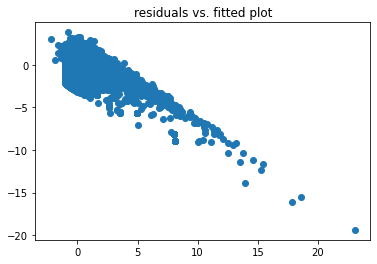

In [5]:
plt.scatter(ols.predict(), ols.resid)
plt.title("residuals vs. fitted plot")
plt.show()

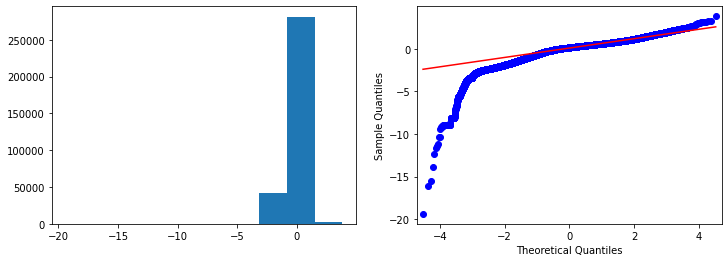

In [7]:
q_q_plot(ols.resid)

In [8]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

<AxesSubplot:>

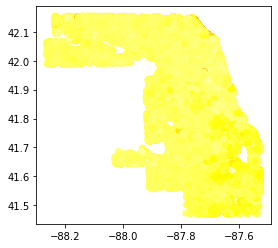

In [9]:
gdf.plot(column=ols.resid, cmap="hot")

In [10]:
w = KNN.from_dataframe(gdf, k=20) # needed k large enough that it was connected
w.transform = 'R'

ValueError: list.remove(x): x not in list

In [ ]:
ols_moran = Moran(ols.resid, w, permutations=199)
plot_moran(ols_moran, zstandard=True, figsize=(10,4))
plt.show()